In [195]:
import torch
from torch.autograd import Variable
from torch.autograd import gradcheck
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

# Introduction

Let's say y = f(x_1, x_2, ..., x_n)
If f is a mathematical function of x_1, x_2, x_3, ..., x_n then we can wire up a neural network to try to find this function given some examples of (x_1, x_2, ...., x_n, y) 

# 1st: Normal Equation Method

In [323]:
# Let's try to find the equation y = 2 * x 
# We have 6 examples:- (x,y) = (0.1,0.2), (1,2), (2, 4), (3, 6), (-4, -8), (25, 50)
# Let's assume y is a linear combination of the features x, x^2, x^3
# We know that Normal Equation gives us the exact solution so let's first use that

N = 6
x = np.array([0.1, 1, 2, 3, -4, 25])
y = np.array([0.2, 2, 4, 6, -8, 50])
x_2 = x**2
x_3 = x**3

X = np.ones((N, 4))
X[:,1] = x
X[:,2] = x_2
X[:,3] = x_3

_, D = np.shape(X)
regularization_strength = 0.0
XtX = (X.T).dot(X)
I = np.eye(D, dtype=float)
XtX_RI = XtX + regularization_strength*I
XtY = (X.T).dot(y)
w = np.linalg.solve(XtX_RI, XtY)
y_pred = X.dot(w)
loss = np.sqrt(np.mean((y_pred-y)**2))
# As expected w ~ [0 2 0 0]
print("W : ", w)
print("Predicted Y : ", y_pred)
print("RMS loss : ", loss)

W :  [ -1.49279111e-14   2.00000000e+00   2.43350714e-15  -1.04209881e-16]
Predicted Y :  [  0.2   2.    4.    6.   -8.   50. ]
RMS loss :  1.1242258769e-14


# 2nd: Neural Network Approach

In [555]:
# Setup the training and test tensors
# Let's generate 400 examples
N = 400
x = np.random.uniform(low=-75, high=100, size=N)
y = 2*x
X = np.zeros((N, 3))
X[:,0] = x
X[:,1] = x**2
X[:,2] = x**3

X_tensor = Variable(torch.FloatTensor(X), requires_grad=False)
y_tensor = Variable(torch.FloatTensor(y), requires_grad=False)

# Test set initialization
X_test = np.zeros((3, 3))
X_test[:,0] = np.array([-2.5, 0.0, 19])
X_test[:,1] = X_test[:,0]**2
X_test[:,2] = X_test[:,0]**3
X_test_tsr = Variable(torch.FloatTensor(X_test), requires_grad=False)

# Normalized features
X_min = torch.min(X_tensor,0)
X_max = torch.max(X_tensor,0)
X_mean = torch.mean(X_tensor,0)
X_sub_mean = X_tensor-X_mean.expand_as(X_tensor)
X_max_min = X_max[0]-X_min[0] + 1e-7
X_norm_tsr = X_sub_mean/X_max_min.expand_as(X_sub_mean)

X_test_sub_mean = X_test_tsr-X_mean.expand_as(X_test_tsr)
X_test_norm_tsr = X_test_sub_mean/X_max_min.expand_as(X_test_sub_mean)

In [663]:
# A simple linear Neural Net which is y = w_1*x + w_2*x^2 + w_3*x^3 + b
import math
from time import time

def RunLinearNNTraining(X, y, learning_rate=1e-5, epochs=5000, batch_size=None, X_test=None, 
                        use_optimizer=None, adam_betas=(0.9, 0.999)):
    # Neural Net
    X_size = X.size()
    N = X_size[0]
    D_in = X_size[1]
    D_out = 1
    model = torch.nn.Linear(D_in, D_out)
    loss_fn = torch.nn.MSELoss(size_average=True)
    
    # Choose Optimizer
    optimizer = None
    if use_optimizer:
        if use_optimizer == 'SGD':
            optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
        elif use_optimizer == 'Adam':
            optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, betas=adam_betas)
        elif use_optimizer == 'Adadelta':
            optimizer = torch.optim.Adadelta(model.parameters(), lr=learning_rate)
        elif use_optimizer == 'ASGD':
            optimizer = torch.optim.ASGD(model.parameters(), lr=learning_rate)
        elif use_optimizer == 'RMSprop':
            optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)
        elif use_optimizer == 'Adagrad':
            optimizer = torch.optim.Adagrad(model.parameters(), lr=learning_rate)
        else:
            print("Invalid Optimizer")
            use_optimizer=None
    
    losses = []
    loss = None
    start_time = time()
    for t in range(epochs):
        num_batches = 1
        X_batch = None
        y_batch = None
        if batch_size:
            num_batches = math.ceil(N/batch_size)
        else:
            batch_size = N
        
        shuffle = torch.randperm(N)
        
        for b in range(num_batches):
            lower_index = b*batch_size
            upper_index = min(lower_index+batch_size, N)
            indices = shuffle[lower_index:upper_index]
            X_batch = X[indices]
            y_batch = y[indices]
                        
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            
            if use_optimizer:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            else:
                # Zero the gradients before running the backward pass.
                model.zero_grad()
                loss.backward()

                # Update the weights using gradient descent. Each parameter is a Variable, so
                # we can access its data and gradients like we did before.
                for param in model.parameters():
                    param.data -= learning_rate * param.grad.data
        losses.append(loss.data[0])

    end_time = time()
    time_taken = end_time - start_time
    print("Time Taken = %.2f seconds " % time_taken)
    print("Final Loss: ", loss.data[0])
    print("Parameters [w_1, w_2, w_3, b]: ")
    for param in model.parameters():
        print(param.data[0])

    # plot Loss vs Iterations
    plt.plot(losses)
    plt.title('Loss history')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.show()
    
    # Predictions on Test set
    if X_test:
        print("Test:")
        print("X_test: ", X_test.data)
        print("y_pred: ", model(X_test))

## Full batch gradient descent with unnormalized features
### SGD, ASGD, Adadelta and Adagrad:
It doesn't converge to global optima and for some of them the learning rate has to be set very low if not the gradients explode. Ouch!

### Adam and RMSprop:
It needs a lot of epochs to converge close to global optima. The solution and loss is not good enough.

Time Taken = 4.29 seconds 
Final Loss:  0.2224656343460083
Parameters [w_1, w_2, w_3, b]: 

 1.9956e+00
-1.8604e-04
 1.4622e-06
[torch.FloatTensor of size 3]

0.7113398909568787


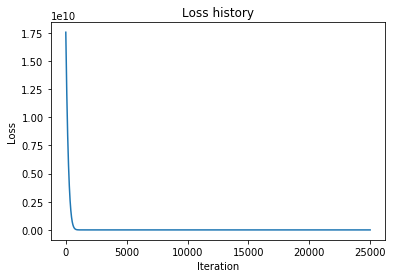

Test:
X_test:  
   -2.5000     6.2500   -15.6250
    0.0000     0.0000     0.0000
   19.0000   361.0000  6859.0000
[torch.FloatTensor of size 3x3]

y_pred:  Variable containing:
 -4.2788
  0.7113
 38.5700
[torch.FloatTensor of size 3x1]



In [628]:
# use_optimizer can be Adam, RMSprop, Adadelta, ASGD, SGD, Adagrad
RunLinearNNTraining(X=X_tensor, y=y_tensor, batch_size=None, epochs=25000, learning_rate=1e-3, 
                    X_test=X_test_tsr, use_optimizer='Adam')

## Full batch gradient descent with feature normalization
Converges more smoothly and better. Needs higher learning_rate (like 100x) than unnormalized features. What else? Even SGD converges and its better than Adam!

Time Taken = 4.18 seconds 
Final Loss:  4.671108513321087e-07
Parameters [w_1, w_2, w_3, b]: 

 3.4974e+02
-6.0098e-04
-6.0013e-04
[torch.FloatTensor of size 3]

18.699024200439453


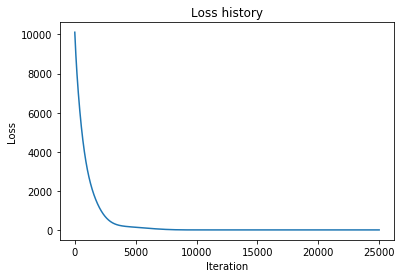

Test:
X_test:  
-0.0678 -0.2538 -0.0544
-0.0535 -0.2544 -0.0544
 0.0552 -0.2182 -0.0496
[torch.FloatTensor of size 3x3]

y_pred:  Variable containing:
-5.0001e+00
-1.4114e-04
 3.8000e+01
[torch.FloatTensor of size 3x1]



In [612]:
# Using Adam Optimizer
RunLinearNNTraining(X=X_norm_tsr, y=y_tensor, batch_size=None, epochs=25000, learning_rate=1e-1, 
                    X_test=X_test_norm_tsr, use_optimizer='Adam')

Time Taken = 3.77 seconds 
Final Loss:  4.048657729072147e-07
Parameters [w_1, w_2, w_3, b]: 

 3.4973e+02
-1.2106e-03
 8.0428e-03
[torch.FloatTensor of size 3]

18.69938087463379


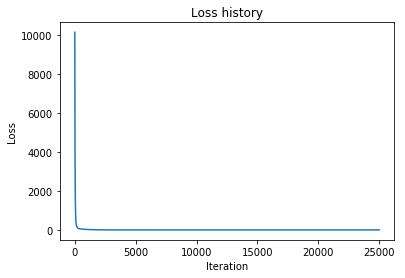

Test:
X_test:  
-0.0678 -0.2538 -0.0544
-0.0535 -0.2544 -0.0544
 0.0552 -0.2182 -0.0496
[torch.FloatTensor of size 3x3]

y_pred:  Variable containing:
-4.9998e+00
 1.5068e-04
 3.8000e+01
[torch.FloatTensor of size 3x1]



In [618]:
# Look SGD is faster than Adam now. It's curve is more steeper.
RunLinearNNTraining(X=X_norm_tsr, y=y_tensor, batch_size=None, epochs=25000, learning_rate=1e-1, 
                    X_test=X_test_norm_tsr, use_optimizer='SGD')

### Mini-Batch Gradient Descent with unnormalized features
Requires much lesser #epochs because in each epoch we are doing more gradient updates due to mini-batches.
It takes longer than Full-Batch Gradient Descent! Ouch! Results are comparable to Full-Batch Gradient Descent.

Time Taken = 6.78 seconds 
Final Loss:  0.04502839222550392
Parameters [w_1, w_2, w_3, b]: 

 2.0033e+00
-2.5394e-05
 6.0180e-07
[torch.FloatTensor of size 3]

0.1875441074371338


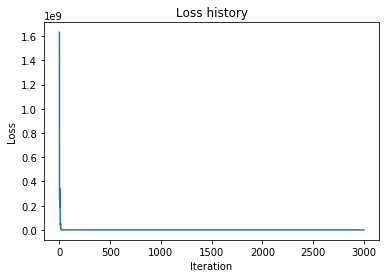

Test:
X_test:  
   -2.5000     6.2500   -15.6250
    0.0000     0.0000     0.0000
   19.0000   361.0000  6859.0000
[torch.FloatTensor of size 3x3]

y_pred:  Variable containing:
 -4.8209
  0.1875
 38.2452
[torch.FloatTensor of size 3x1]



In [623]:
# SGD doesn't work with unnormalized features so using Adam.
RunLinearNNTraining(X=X_tensor, y=y_tensor, batch_size=25, epochs=3000, learning_rate=1e-3, 
                    X_test=X_test_tsr, use_optimizer='Adam')

### Mini-Batch Gradient Descent with normalized features
Cool! normalization of features is better for convergence.
It takes longer than Full-Batch Gradient Descent and results are comparable to Full-Batch Gradient Descent with normalized features.

Time Taken = 6.35 seconds 
Final Loss:  8.189108768874576e-08
Parameters [w_1, w_2, w_3, b]: 

 3.4974e+02
-5.1438e-04
 3.4505e-03
[torch.FloatTensor of size 3]

18.699392318725586


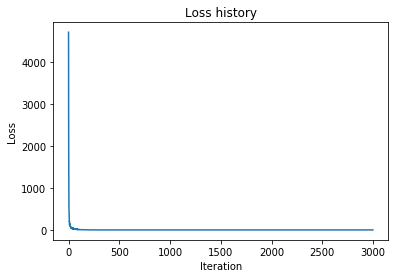

Test:
X_test:  
-0.0678 -0.2538 -0.0544
-0.0535 -0.2544 -0.0544
 0.0552 -0.2182 -0.0496
[torch.FloatTensor of size 3x3]

y_pred:  Variable containing:
-4.9999e+00
 7.6294e-05
 3.8000e+01
[torch.FloatTensor of size 3x1]



In [629]:
# SGD is better than Adam in this case so using SGD
RunLinearNNTraining(X=X_norm_tsr, y=y_tensor, batch_size=25, epochs=3000, learning_rate=1e-1, 
                    X_test=X_test_norm_tsr, use_optimizer='SGD')

### Mini-Batch Gradient Descent with normalized features and batch_size = 1
Its much faster and better than the previous approaches for this problem. Awesome!

Time Taken = 1.31 seconds 
Final Loss:  7.161030225688592e-06
Parameters [w_1, w_2, w_3, b]: 

 349.6919
  -0.0185
   0.0851
[torch.FloatTensor of size 3]

18.701908111572266


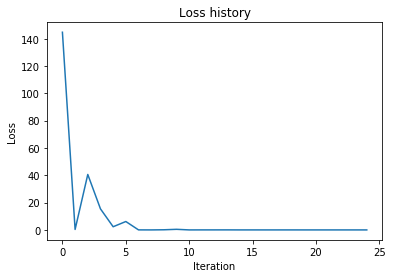

Test:
X_test:  
-0.0678 -0.2538 -0.0544
-0.0535 -0.2544 -0.0544
 0.0552 -0.2182 -0.0496
[torch.FloatTensor of size 3x3]

y_pred:  Variable containing:
 -4.9942
  0.0051
 37.9998
[torch.FloatTensor of size 3x1]



In [636]:
# SGD is better than Adam in this case so using SGD
RunLinearNNTraining(X=X_norm_tsr, y=y_tensor, batch_size=1, epochs=25, learning_rate=1e-1, 
                    X_test=X_test_norm_tsr, use_optimizer='SGD')

### Mini-Batch Gradient Descent with UNnormalized features and batch_size = 1
SGD doesn't converge and Adam performs bad. Well, worth a try.

Time Taken = 8.41 seconds 
Final Loss:  21.661556243896484
Parameters [w_1, w_2, w_3, b]: 

 1.6934e+00
-2.8070e-03
 6.3677e-05
[torch.FloatTensor of size 3]

-0.26881924271583557


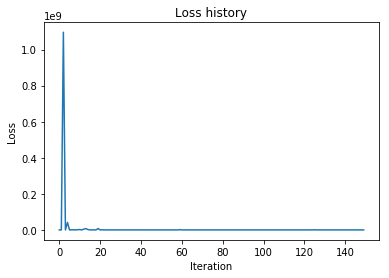

Test:
X_test:  
   -2.5000     6.2500   -15.6250
    0.0000     0.0000     0.0000
   19.0000   361.0000  6859.0000
[torch.FloatTensor of size 3x3]

y_pred:  Variable containing:
 -4.5208
 -0.2688
 31.3291
[torch.FloatTensor of size 3x1]



In [645]:
RunLinearNNTraining(X=X_tensor, y=y_tensor, batch_size=1, epochs=150, learning_rate=1e-3, 
                    X_test=X_test_tsr, use_optimizer='Adam')

### Can we get away not having to use normalized features and achieve good performance?
We have seen till now that normalizing features, mini-batches of size 1 and SGD optimizer gave us one of the fastest and best convergences. Wouldn't it be cool if we don't have to normalize features? After all, we are trying to converge to a simple y = 2*x equation.

The answer to why Adam and RMSprop optimizers work with unnormalized raw features is the factor ***1/sqrt(norm(gradients))*** which makes sure the gradients don't explode.

If we want to use unnormalized features then it's best to use Adam optimizer and full batches for training.

Time Taken = 4.13 seconds 
Final Loss:  0.9092176556587219
Parameters [w_1, w_2, w_3, b]: 

 2.0000e+00
 3.5566e-06
 3.5570e-06
[torch.FloatTensor of size 3]

3.750398491320084e-06


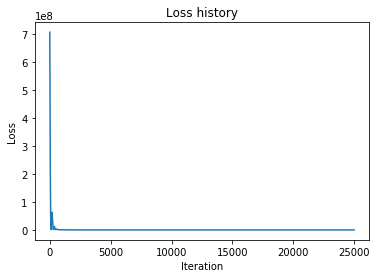

Test:
X_test:  
   -2.5000     6.2500   -15.6250
    0.0000     0.0000     0.0000
   19.0000   361.0000  6859.0000
[torch.FloatTensor of size 3x3]

y_pred:  Variable containing:
-5.0000e+00
 3.7504e-06
 3.8026e+01
[torch.FloatTensor of size 3x1]



In [697]:
RunLinearNNTraining(X=X_tensor, y=y_tensor, batch_size=None, epochs=25000, learning_rate=1e-3, 
                    X_test=X_test_tsr, use_optimizer='Adam', adam_betas=(0.99, 0.999))